In [1]:
import torch
from circuits import Circuit,Kinds
from learn import Trainer
from data import Data

In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)
torch.set_printoptions(precision=3, linewidth=200)

Using cpu device


[(IVS, 1, 0), (R, 1, 0), (R, 1, 0)]


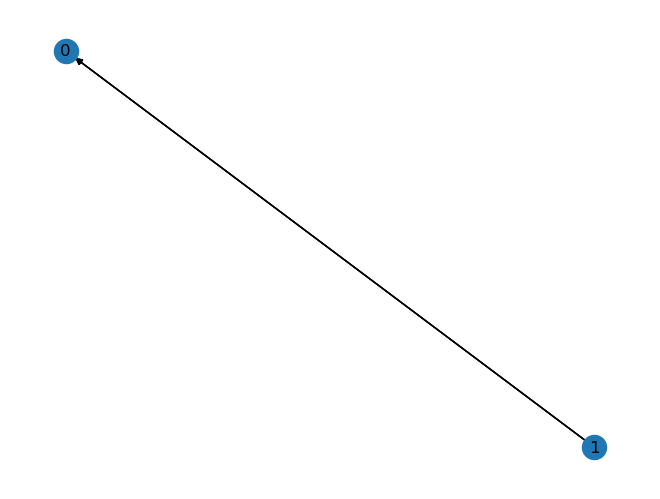

In [3]:
vr = Circuit()
# vr.ring(Kinds.IVS,Kinds.R,2)
vr.ladder(Kinds.IVS,Kinds.R,2)
vr.elements[0].attr = 1e6
vr.elements[-1].v = 1
print(vr.elements)
vr.draw()

In [4]:
data = Data(vr)
trainer = Trainer(data, 1e-1)

c:\Users\terry\OneDrive\Documents\GitHub\side_circuit\ml\circuits.py:112: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_scipy = nx.incidence_matrix(G=self.nx_graph(),oriented=True)


In [5]:
stable_threshold = 1e-5
loss_threshold = 1e-20
i_sol,v_sol,a_sol,loss,epoch = trainer.run(1000, stable_threshold, loss_threshold)
vr.load(i_sol,v_sol,a_sol)
i_sol,v_sol,a_sol,epoch

RuntimeError: linalg.solve: Incompatible shapes of A and B for the equation AX = B (6x6 and 7x1)

In [ ]:
vr.elements[0].i, vr.elements[0].v, vr.elements[0].attr

(-787787.3125, 1000000.0, 1000000.0)

In [ ]:
vr.elements[1].i, vr.elements[1].v, vr.elements[1].attr

(787787.3125, 999999.0, 1269376.875)

In [ ]:
vr.elements[2].i, vr.elements[2].v, vr.elements[2].attr

(787787.3125, 1.0, 1.2693780660629272)